In [1]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
N_SAMPLES = 10000
N_FEATURES = 2
N_CLASSES = 4

In [4]:
X,y = make_blobs(n_samples=N_SAMPLES, n_features=N_FEATURES, centers=N_CLASSES, cluster_std = 3, random_state=42)

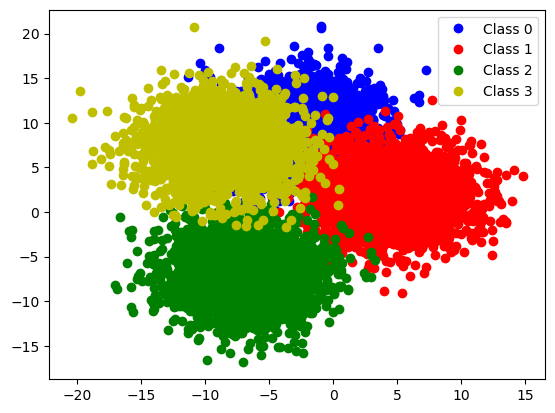

In [5]:
plt.plot(X[y==0,0], X[y==0,1], 'bo', label='Class 0')
plt.plot(X[y==1,0], X[y==1,1], 'ro', label='Class 1')
plt.plot(X[y==2,0], X[y==2,1], 'go', label='Class 2')
plt.plot(X[y==3,0], X[y==3,1], 'yo', label='Class 3')
plt.legend()

In [6]:
len(X), len(y)

(10000, 10000)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
len(X_train), len(y_train), len(X_test), len(y_test)

(8000, 8000, 2000, 2000)

In [9]:
y_train[0]

0

In [10]:
class MultiClassModel(nn.Module):

    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear1 = nn.Linear(in_features, 16)
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 64)
        self.linear4 = nn.Linear(64, 32)
        self.linear5 = nn.Linear(32, out_features)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, X: torch.tensor) -> torch.tensor:
        X = self.relu(self.linear1(X))
        X = self.relu(self.linear2(X))
        X = self.relu(self.linear3(X))
        X = self.relu(self.linear4(X))
        X = self.softmax(self.linear5(X))
        return X

In [11]:
model = MultiClassModel(N_FEATURES, N_CLASSES).to(device)

In [12]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [13]:
with torch.inference_mode():
    y_pred = model(torch.from_numpy(X_train).float().to(device))
    loss = loss_function(y_pred, torch.from_numpy(y_train).to(device).long())

y_pred[0]

tensor([0.3225, 0.2483, 0.2405, 0.1888], device='cuda:0')

In [14]:
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).to(device)

y_train = y_train.long()
y_test = y_test.long()

In [15]:
EPOCHS = 2000

In [16]:
epochs = []
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

In [17]:
import torch
from torchmetrics.classification import Precision, Recall, Accuracy

# Initialize metrics with the 'task' argument
precision = Precision(task='multiclass', average='macro', num_classes=4).to(device)  # Modify num_classes as per your requirement
recall = Recall(task='multiclass', average='macro', num_classes=4).to(device)
accuracy = Accuracy(task='multiclass', average='macro', num_classes=4).to(device)

# Track train and test metrics
train_precision_scores, train_recall_scores, train_accuracy_scores = [], [], []
test_precision_scores, test_recall_scores, test_accuracy_scores = [], [], []

for epoch in range(EPOCHS):

    model.train()
    
    y_logits = model(X_train)
    loss = loss_function(y_logits, y_train)
    train_loss.append(loss.item())

    # Compute accuracy, precision, and recall for training data
    train_preds = y_logits.argmax(dim=1)
    train_accuracy_scores.append(accuracy(train_preds, y_train).item())
    train_precision_scores.append(precision(train_preds, y_train).item())
    train_recall_scores.append(recall(train_preds, y_train).item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    
    with torch.inference_mode():
        y_logits = model(X_test)
        loss = loss_function(y_logits, y_test)
        test_loss.append(loss.item())

        # Compute accuracy, precision, and recall for test data
        test_preds = y_logits.argmax(dim=1)
        test_accuracy_scores.append(accuracy(test_preds, y_test).item())
        test_precision_scores.append(precision(test_preds, y_test).item())
        test_recall_scores.append(recall(test_preds, y_test).item())

    # Print results every 100 epochs
    if epoch % 100 == 0:
        print(f'Epoch: {epoch} | Train Loss: {train_loss[-1]:.4f} | Test Loss: {test_loss[-1]:.4f} | '
              f'Train Accuracy: {train_accuracy_scores[-1]:.4f} | Test Accuracy: {test_accuracy_scores[-1]:.4f} | '
              f'Train Precision: {train_precision_scores[-1]:.4f} | Test Precision: {test_precision_scores[-1]:.4f} | '
              f'Train Recall: {train_recall_scores[-1]:.4f} | Test Recall: {test_recall_scores[-1]:.4f}')

Epoch: 0 | Train Loss: 1.3884 | Test Loss: 1.3614 | Train Accuracy: 0.2500 | Test Accuracy: 0.2515 | Train Precision: 0.0625 | Test Precision: 0.3126 | Train Recall: 0.2500 | Test Recall: 0.2515
Epoch: 100 | Train Loss: 0.8415 | Test Loss: 0.8458 | Train Accuracy: 0.9007 | Test Accuracy: 0.8973 | Train Precision: 0.9009 | Test Precision: 0.8975 | Train Recall: 0.9007 | Test Recall: 0.8973
Epoch: 200 | Train Loss: 0.8404 | Test Loss: 0.8460 | Train Accuracy: 0.9026 | Test Accuracy: 0.8967 | Train Precision: 0.9028 | Test Precision: 0.8974 | Train Recall: 0.9026 | Test Recall: 0.8967
Epoch: 300 | Train Loss: 0.8426 | Test Loss: 0.8463 | Train Accuracy: 0.8999 | Test Accuracy: 0.8972 | Train Precision: 0.9011 | Test Precision: 0.8981 | Train Recall: 0.8999 | Test Recall: 0.8972
Epoch: 400 | Train Loss: 0.8402 | Test Loss: 0.8462 | Train Accuracy: 0.9020 | Test Accuracy: 0.8962 | Train Precision: 0.9021 | Test Precision: 0.8970 | Train Recall: 0.9020 | Test Recall: 0.8962
Epoch: 500 | Trai

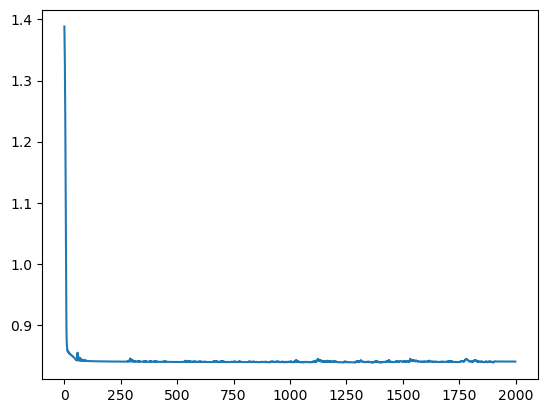

In [18]:
plt.plot(train_loss, label='train loss')

In [19]:
from helper_functions import plot_decision_boundary

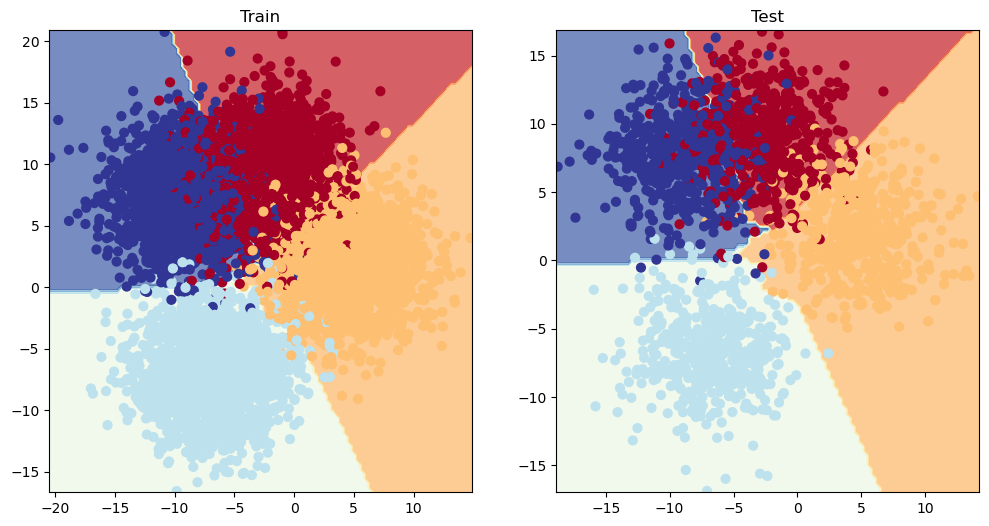

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)
plt.show()